L

In this section, we start designing FIR filters using the windowing design method. This is the most straightforward design method.


In [57]:
import numpy as np
from numpy import pi, sinc, arange, log10
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal, fft
from scipy.signal import firwin, kaiserord, freqz, tf2sos, sosfreqz
from scipy.signal.windows import kaiser
from utils import plot_impulse_response, plot_frequency_response_direct, plot_frequency_response_cascade

In [58]:
# Filter requirements
fs = 1000 # Sample rate, Hz
cutoff = np.pi / 2 # Desired cutoff frequency, Hz
trans_width = 0.1 * np.pi # Width of transition from pass band to stop band, Hz
numtaps = 15 # Size of the FIR filter

## Windowing Method

Consider an ideal low-pass filter with linear phase:

$$
H_d(e^{j\omega}) = 
\begin{cases} 
e^{-j\omega n_d}, & |ω| ≤ ω_c \\
0, & ω_c < |ω| ≤ π 
\end{cases}
$$

The corresponding ideal impulse response is:

$$
h_d[n] = \frac{\sin(ω_c(n − n_d))}{π(n − n_d)}, \quad -∞ < n < ∞
$$

Note that the impulse response has infinite duration and is non-causal. One solution to this is to truncate the impulse response, taking \(N = M + 1\) samples (\(M = 2n_d\)):

$$
h[n] =
\begin{cases} 
h_d[n], & 0 ≤ n ≤ M = 2n_d = N − 1 \\
0, & otherwise 
\end{cases}
$$

This is equivalent to multiplying the ideal impulse response \(h_d[n]\) by a finite-duration window \(w[n]\):

$$
h[n] = h_d[n] · w[n]
$$

In the case of a simple truncation, \(w[n]\) is a rectangular window:

$$
w[n] =
\begin{cases} 
1, & 0 ≤ n ≤ M = N − 1 \\
0, & otherwise 
\end{cases}
$$


# Kaiser

The most popular window used for this method of filter design is the Kaiser-Bessel window because it provides extra parameters for tuning the frequency response.

A janela de Kaiser é definida como:

$$
w[n] = 
\begin{cases} 
\frac{I_0\left(\beta \sqrt{1 - \left(\frac{n - \alpha}{\alpha}\right)^2}\right)}{I_0(\beta)}, & 0 \leq n \leq M, \\
0, & \text{caso contrário},
\end{cases}
$$

onde:

- \( $\beta$ \) é o parâmetro da janela de Kaiser, que controla o trade-off entre a largura da banda de transição e a atenuação da banda de rejeição.
- \( $\alpha$ \) é dado por \( $\alpha = \frac{M}{2}$ \), onde \( M \) é a ordem do filtro.
- \( $I_0$ \) é a função modificada de Bessel de primeira espécie e ordem zero.


Ao contrário de outras janelas, a de Kaiser tem dois parâmetros: o comprimento (M + 1)
e o parâmetro de forma β. Variando-se (M + 1) e β, o comprimento da janela e sua forma podem ser ajustados para trocar amplitude do lóbulo lateral por largura do lóbulo principal.

Pela equação vemos que o caso β = 0 se reduz à janela retangular.

The signal.fir_filter_design module provides functions for filter design using the Kaiser-Bessel window ( among other windows). For example, to design a lowpass filter using the Kaiser-Bessel window, we need the a subset of the following parameters: maximum passband ripple (
), width of the transition region, Kaiser-Bessel parameter 
, and the number of filter taps. The fir_filter_design provides tools to solve for some of these parameters given others. For example, the fir_filter_design.kaiserord() function can determine the number of taps given the maximum allowable passband ripple and the width of the transition region.

Consider the following low pass filter specification.

### Design Especification 

In [59]:
# Parâmetros do problema
fs = 2  # Frequência de amostragem (normalizada)
wc = np.pi / 2  # Frequência de corte em radianos
cutoff = wc / np.pi  # Frequência de corte normalizada

# Especificações do filtro
attenuation = 50  # Atenuação mínima na banda rejeitada em dB
transition_width = 0.1  # Largura da banda de transição em π radianos

### Low pass with firwin

In [60]:
# Calculando a ordem do filtro e o parâmetro beta da janela de Kaiser
M, beta = kaiserord(attenuation, transition_width)

# Projetando o filtro FIR utilizando a função firwin e a janela de Kaiser
h = firwin(M, cutoff=cutoff, window=('kaiser', beta), fs=fs)

# Resposta em frequência
w, H = freqz(h, worN=8000)

### Plots

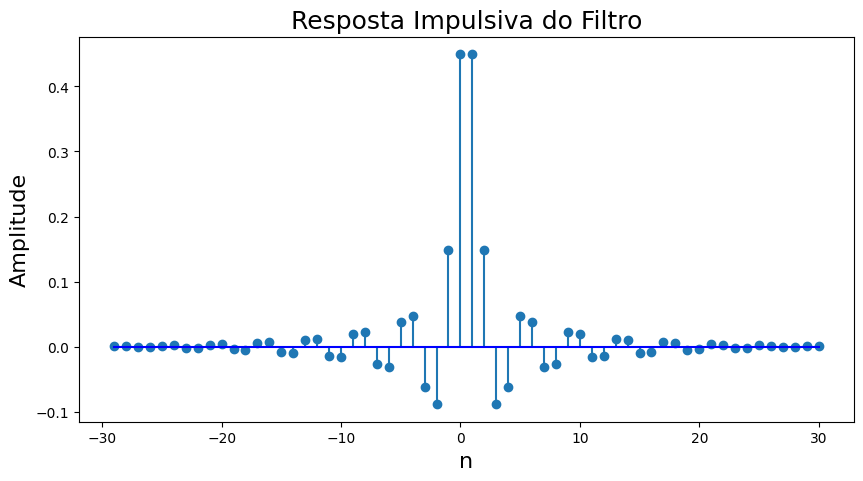

In [61]:
plot_impulse_response(M, h)

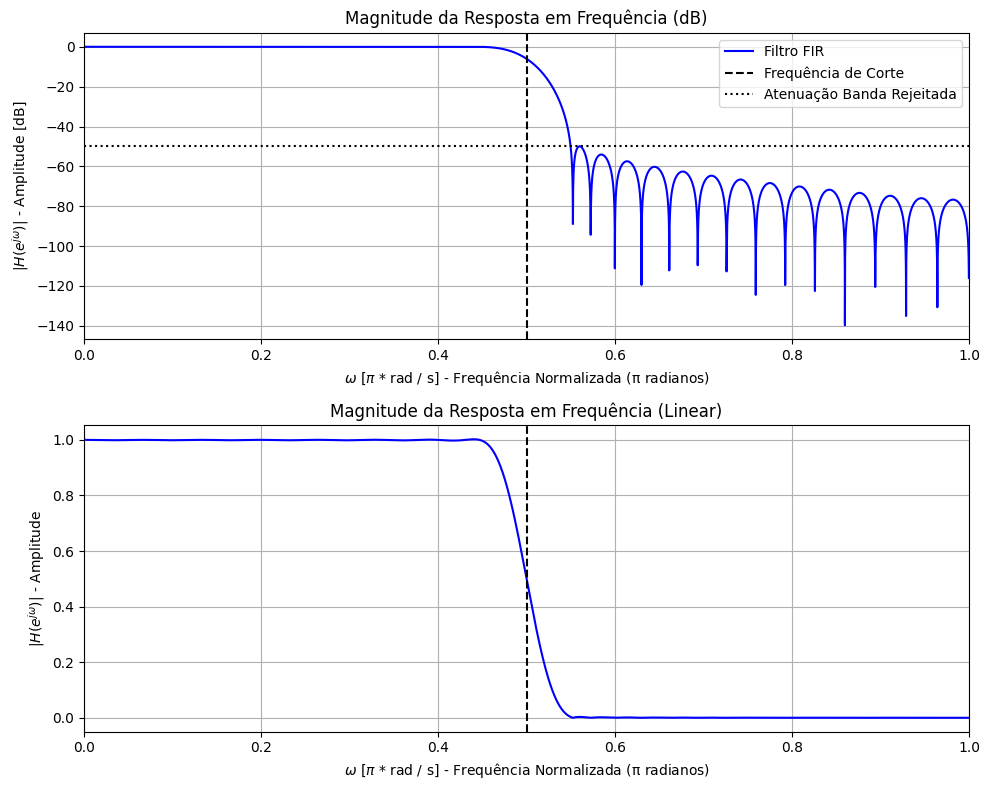

In [62]:
axs = plot_frequency_response_direct(w, H)

# Especificações
axs[1].axvline(wc / np.pi, color='k', linestyle='--', label='Frequência de Corte')
axs[0].axvline(wc / np.pi, color='k', linestyle='--', label='Frequência de Corte')
axs[0].axhline(-attenuation, color='k', linestyle=':', label='Atenuação Banda Rejeitada')
axs[0].legend()
plt.show()

In [63]:
print(f'Número de taps do filtro: {numtaps}')
print(f'Parâmetro beta da janela de Kaiser: {beta:.2f}')

Número de taps do filtro: 15
Parâmetro beta da janela de Kaiser: 4.53


The figure above shows the frequency response using a Hamming window to gently terminate the filter sequence. Note that the Gibbs effect is significantly reduced, producing a much flatter mainlobe at the cost of a wider mainlobe. The mainlobe widens because the mainlobe of the Hamming window is wider than that of the rectangular window. The much lower sidelobes of the Hamming window flattens the Gibbs phenomenon at the edge of the passband.

### Filtro feito com menos funções auxiliares com o mesmo resultado

In [64]:
# Definir parâmetros do filtro
As = 50  # Atenuação mínima na banda de rejeição (dB)
delta_w = 0.1 * np.pi  # Largura de transição

# Calcular o parâmetro beta_kaiser da janela de Kaiser
beta_kaiser = 0
if As > 50:
    beta_kaiser = 0.1102 * (As - 8.7)
elif As >= 21:
    beta_kaiser = 0.5842 * (As - 21)**0.4 + 0.07886 * (As - 21)

# Calcular o comprimento do filtro
N_kaiser = int(np.ceil((As - 8) / (2.285 * delta_w))) + 1
if N_kaiser % 2 == 0:
    N_kaiser += 1  # Certifique-se de que N_kaiser seja ímpar

# Gerar a resposta ao impulso do filtro ideal (sinc function)
n_kaiser = np.arange(N_kaiser)
h_kaiser = np.sinc((n_kaiser - (N_kaiser - 1) / 2) * wc / np.pi)

# Aplicar a janela de Kaiser
window = kaiser(N_kaiser, beta_kaiser)
h_kaiser = h_kaiser * window

# Normalizar o filtro
h_kaiser /= np.sum(h_kaiser)

w_kaiser, H_kaiser = freqz(h_kaiser, worN=8000)

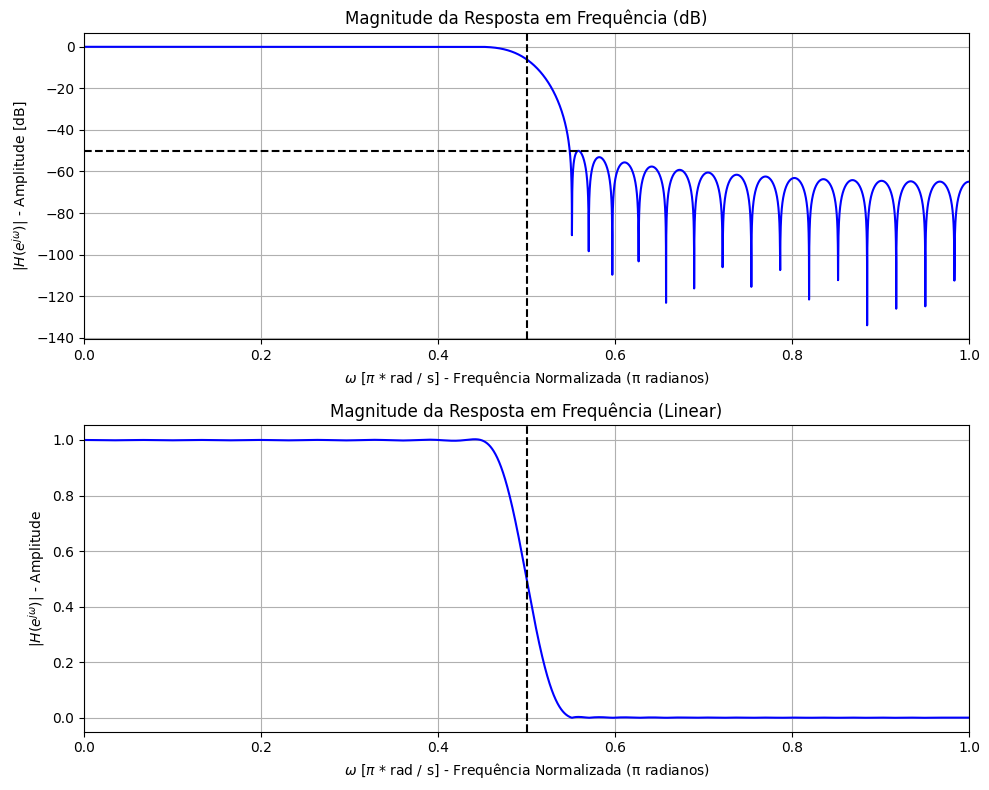

In [65]:
fig,axs = plt.subplots(2, 1, figsize=(10, 8))
axs = plot_frequency_response_direct(w_kaiser, H_kaiser, fig, axs)

axs[1].axvline(wc / np.pi, color="k", linestyle="--")

axs[0].axvline(wc / np.pi, color='k', linestyle='--', label='Frequência de Corte')
axs[0].axhline(-As, color='k', linestyle='--', label='Atenuação Banda Rejeitada')

# fig.suptitle("Resposta em frequência - Forma direta")

### TO DO: não consgui fazer esse grafico ficar com as cores bonitinhas nos trechos certos que eu vi na net

In [66]:
# w = w / np.pi  # Normalizar para frequência em múltiplos de π

# # Parâmetros de plotagem
# fpass = cutoff
# fstop = fpass + transition_width
# ymin, ymax = -80, 5

# # Criar o gráfico
# fig, ax = plt.subplots()
# fig.set_size_inches((8, 3))

# ax.plot(w * fs / 2., 20 * np.log10(abs(H)), label='Resposta em Frequência')
# ax.set_xlabel("Frequência (Hz)", fontsize=16)
# ax.set_ylabel("Magnitude (dB)", fontsize=22)
# ax.axis([0, fs / 2, ymin, ymax])

# # Adicionar áreas de banda de passagem e rejeição
# ax.add_patch(plt.Rectangle((0, ymin), width=fpass, height=ymax-ymin, color='g', alpha=0.3))
# ax.add_patch(plt.Rectangle((fpass, ymin), width=fstop-fpass, height=ymax-ymin, color='r', alpha=0.3))
# ax.add_patch(plt.Rectangle((fstop, ymin), width=fs/2-fstop, height=ymax-ymin, color='y', alpha=0.3))

# # Adicionar título e legendas
# ax.set_title(f"Número de taps = {M}", fontsize=16)
# ax.text(0.05, -15, 'Banda de Passagem', fontsize=14, bbox=dict(color='white'))
# ax.text(fpass + 0.05, -15, 'Banda de Rejeição', fontsize=16, bbox=dict(color='white'))
# ax.grid()
# ax.legend()

# # Mostrar o gráfico
# plt.show()

## Cascata

Para converter o filtro FIR para a forma em cascata e utilizar tf2sos para obter os coeficientes, você pode seguir estes passos:

* Transformar o filtro FIR em uma representação em cascata:
    * A função tf2sos pode ser utilizada para converter a representação de um filtro em formato de coeficientes de numerador e denominador para uma forma em cascata.
* Aplicar os subfiltros em cascata e plotar a resposta em frequência:
    * Divida o filtro FIR em uma série de filtros em cascata e aplique cada filtro na sequência.

In [67]:
h

array([ 4.23478081e-04,  6.01794885e-04, -8.15510001e-04, -1.06858910e-03,
        1.36528768e-03,  1.71019999e-03, -2.10832614e-03, -2.56516332e-03,
        3.08682897e-03,  3.68022707e-03, -4.35327277e-03, -5.11519724e-03,
        5.97696448e-03,  6.95184702e-03, -8.05623147e-03, -9.31076398e-03,
        1.07420108e-02,  1.23849207e-02, -1.42865766e-02, -1.65120928e-02,
        1.91542374e-02,  2.23498459e-02, -2.63093603e-02, -3.13736269e-02,
        3.81326423e-02,  4.77026060e-02, -6.24778906e-02, -8.86876910e-02,
        1.49179179e-01,  4.49598222e-01,  4.49598222e-01,  1.49179179e-01,
       -8.86876910e-02, -6.24778906e-02,  4.77026060e-02,  3.81326423e-02,
       -3.13736269e-02, -2.63093603e-02,  2.23498459e-02,  1.91542374e-02,
       -1.65120928e-02, -1.42865766e-02,  1.23849207e-02,  1.07420108e-02,
       -9.31076398e-03, -8.05623147e-03,  6.95184702e-03,  5.97696448e-03,
       -5.11519724e-03, -4.35327277e-03,  3.68022707e-03,  3.08682897e-03,
       -2.56516332e-03, -

In [68]:
# O filtro FIR pode ser considerado como um filtro IIR com coeficientes denominadores iguais a 1
sos = tf2sos(h, [1.0])  # Convertendo para a forma de seções de segundo ordem

# Resposta em frequência para o filtro em cascata
w_cascade, H_cascade = sosfreqz(sos, worN=8000)

n = np.arange(len(h))

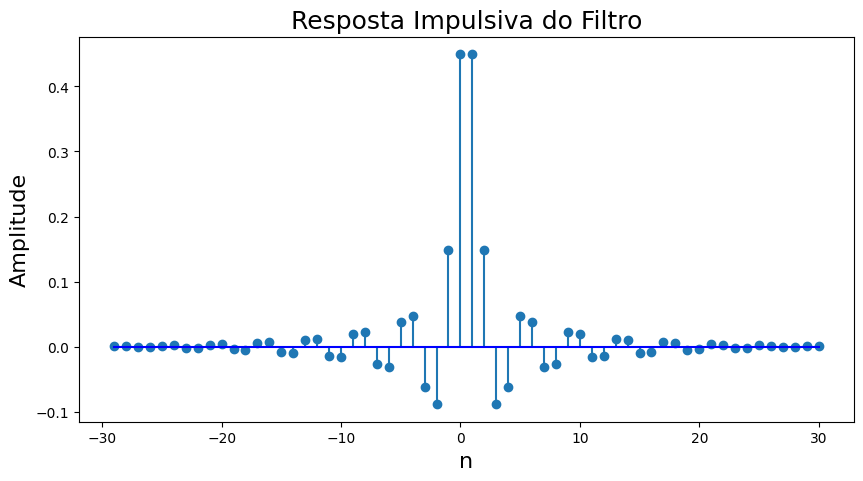

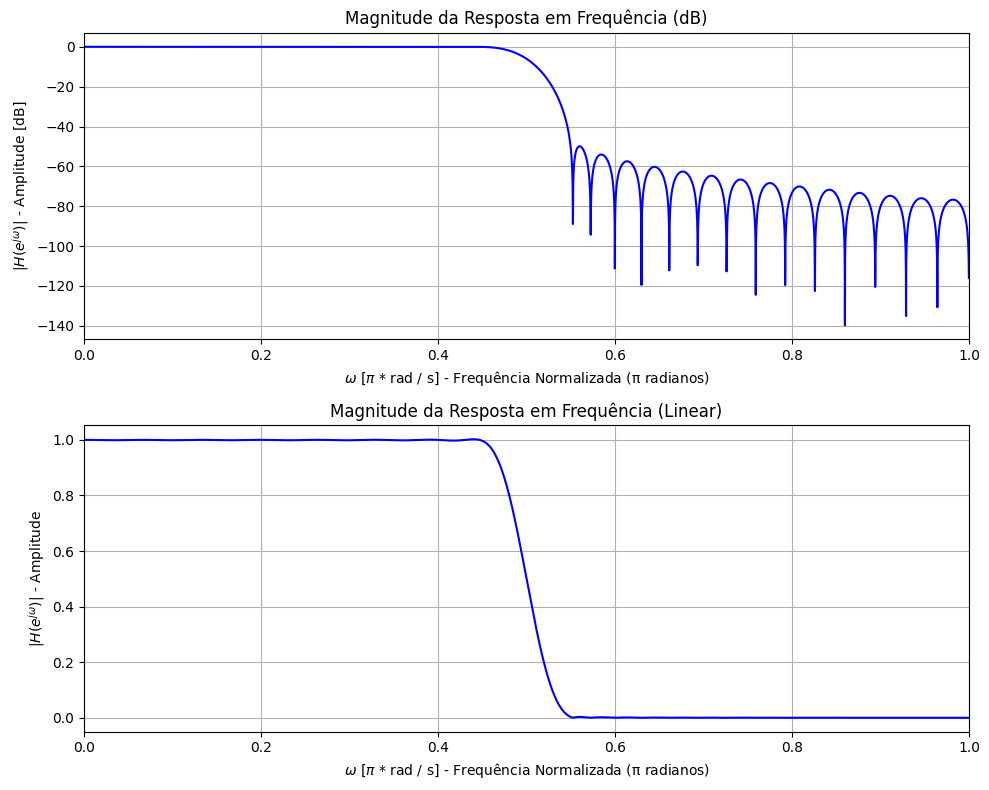

In [69]:
plot_impulse_response(M, h)
plot_frequency_response_direct(w_cascade, H_cascade)

axs[1].axvline(wc / np.pi, color="k", linestyle="--")

axs[0].axvline(wc / np.pi, color='red', linestyle='--', label='Frequência de Corte')
axs[0].axhline(-As, color='green', linestyle='--', label='Atenuação Banda Rejeitada')

In [70]:
# # Plotando os gráficos
# fig, axs = plt.subplots(3, 1, figsize=(8, 12))
# plt.subplots_adjust(hspace=0.8)

# # Resposta impulsiva do filtro
# ax = axs[0]
# ax.stem(n - (M - 1) // 2, h, basefmt='b-', label='Filtro Direto')
# ax.set_xlabel("n", fontsize=16)
# ax.set_ylabel("Amplitude", fontsize=16)
# ax.set_title("Resposta Impulsiva do Filtro", fontsize=18)
# ax.legend()

# # Magnitude da resposta em frequência
# ax = axs[1]
# ax.plot(w * np.pi, abs(H), label='Filtro Direto')
# ax.plot(w_cascade * np.pi, abs(H_cascade), label='Filtro em Cascata', linestyle='--')
# ax.vlines([wc], 0, 1.2 * max(np.max(abs(H)), np.max(abs(H_cascade))), color='g', lw=2., linestyle='--')
# ax.hlines(1, -np.pi, np.pi, color='g', lw=2., linestyle='--')
# ax.set_xlabel(r"$\omega$", fontsize=22)
# ax.set_ylabel(r"$|H(\omega)|$", fontsize=22)
# ax.set_title("Magnitude de Resposta em Frequência", fontsize=18)
# ax.grid()
# ax.legend()

# # Resposta em frequência em dB
# ax = axs[2]
# ax.plot(w * np.pi, 20 * np.log10(abs(H)), label='Filtro Direto')
# ax.plot(w_cascade * np.pi, 20 * np.log10(abs(H_cascade)), label='Filtro em Cascata', linestyle='--')
# ax.vlines([wc], -60, 5, color='g', lw=2., linestyle='--')
# ax.hlines(0, -np.pi, np.pi, color='g', lw=2., linestyle='--')
# ax.set_xlabel(r"$\omega$", fontsize=22)
# ax.set_ylabel(r"$20\log_{10}|H(\omega)|$", fontsize=18)
# ax.set_title("Resposta em Frequência em dB", fontsize=18)
# ax.grid()
# ax.legend()

# plt.show()

## Diminuindo o número de casas decimais

### Forma direta

array([<Axes: title={'center': 'Magnitude da Resposta em Frequência (dB)'}, xlabel='$\\omega$ [$\\pi$ * rad / s] - Frequência Normalizada (π radianos)', ylabel='$|H(e^{j\\omega})|$ - Amplitude [dB]'>,
       <Axes: title={'center': 'Magnitude da Resposta em Frequência (Linear)'}, xlabel='$\\omega$ [$\\pi$ * rad / s] - Frequência Normalizada (π radianos)', ylabel='$|H(e^{j\\omega})|$ - Amplitude'>],
      dtype=object)

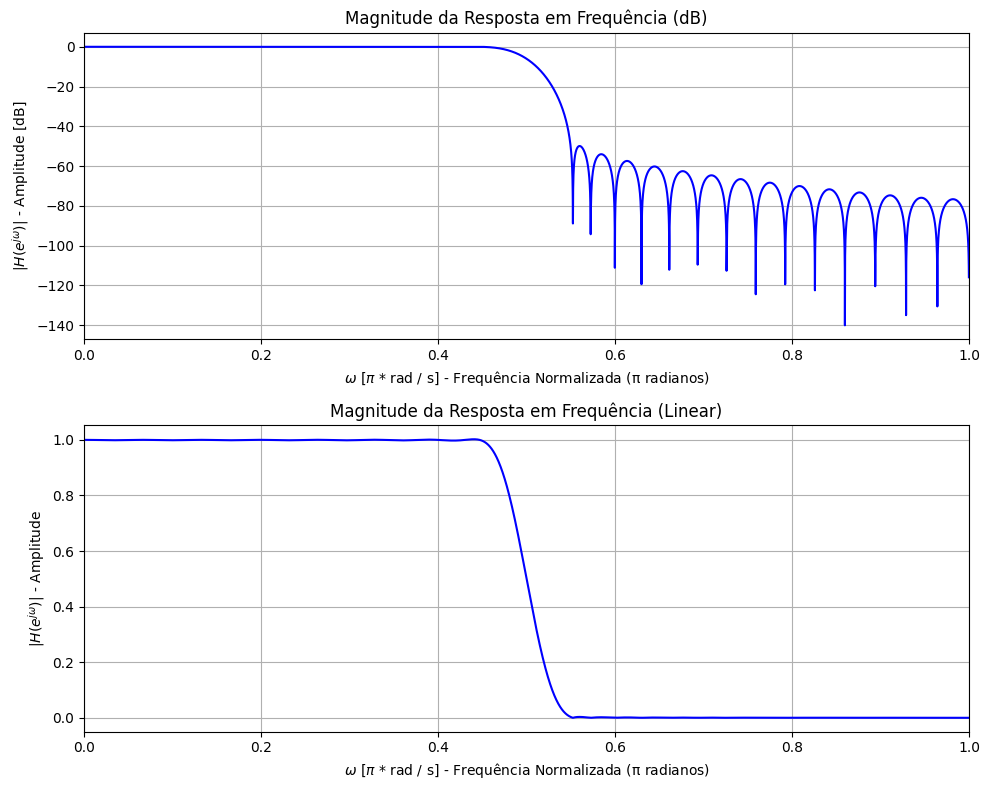

In [71]:
n_casas = 8
_w = np.round(w, decimals=n_casas)
_H = np.round(H, decimals=n_casas)

plot_frequency_response_direct(w, _H)

C:\Users\darth\AppData\Local\Temp\ipykernel_20980\776963740.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_casas - min_casas)  # 'tab10' é um mapa de cores com 10 cores diferentes


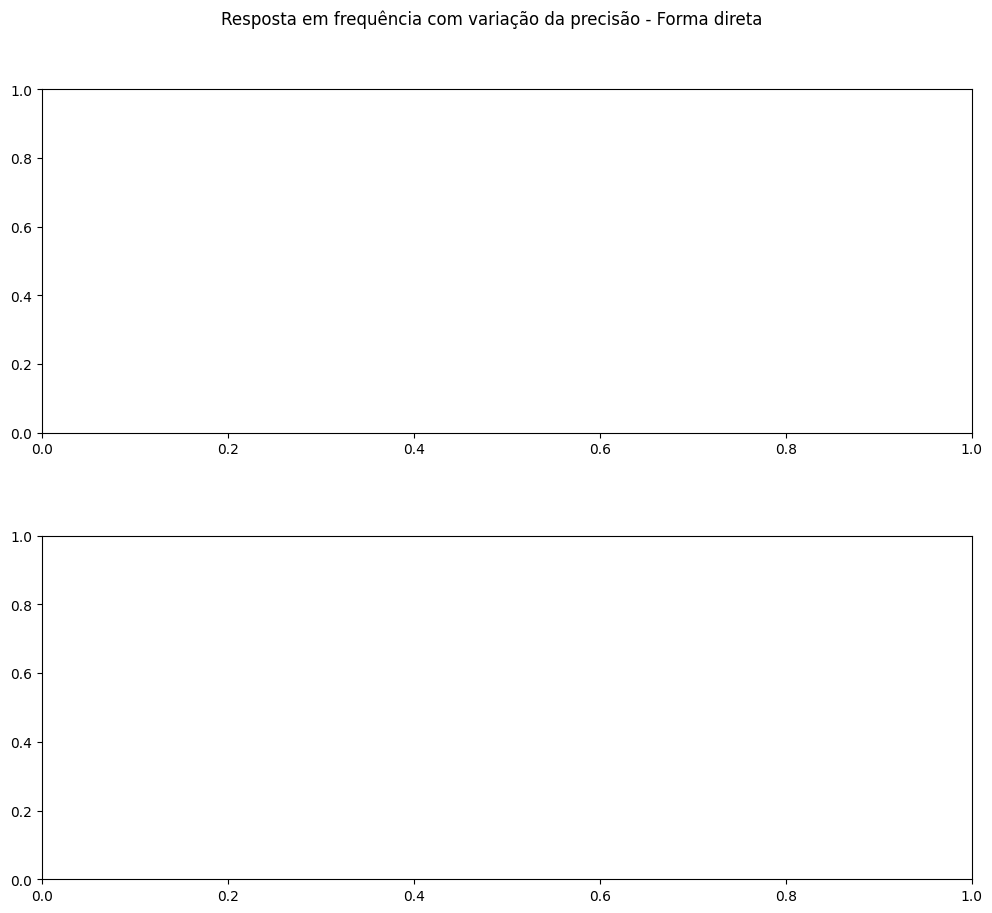

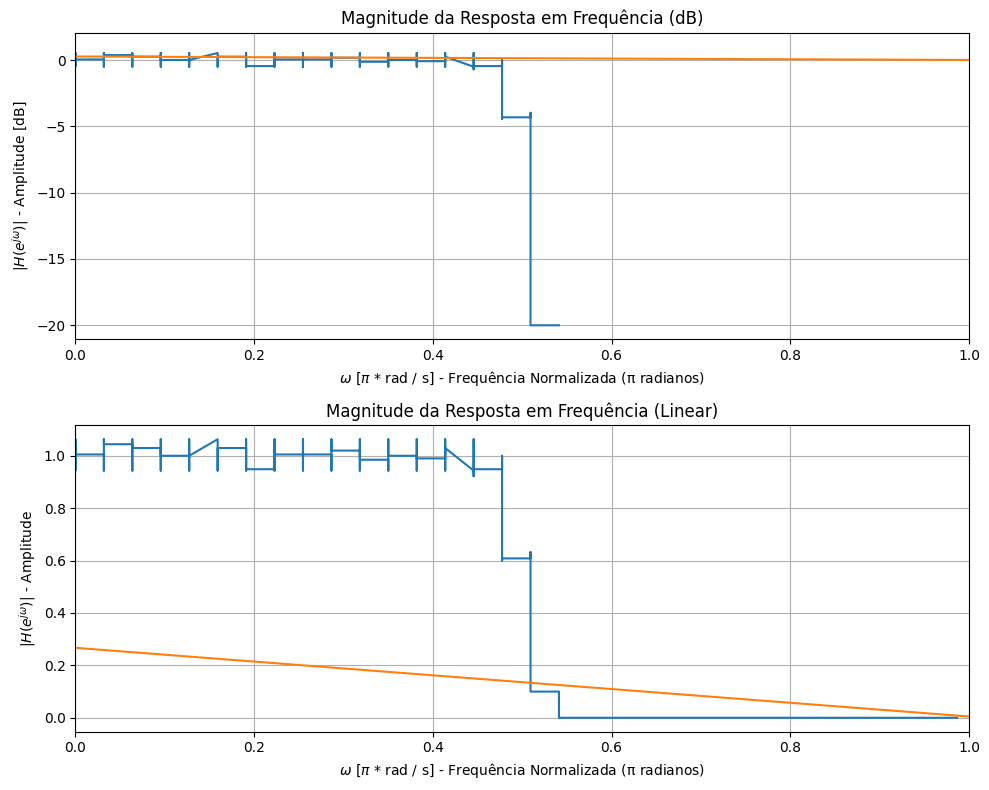

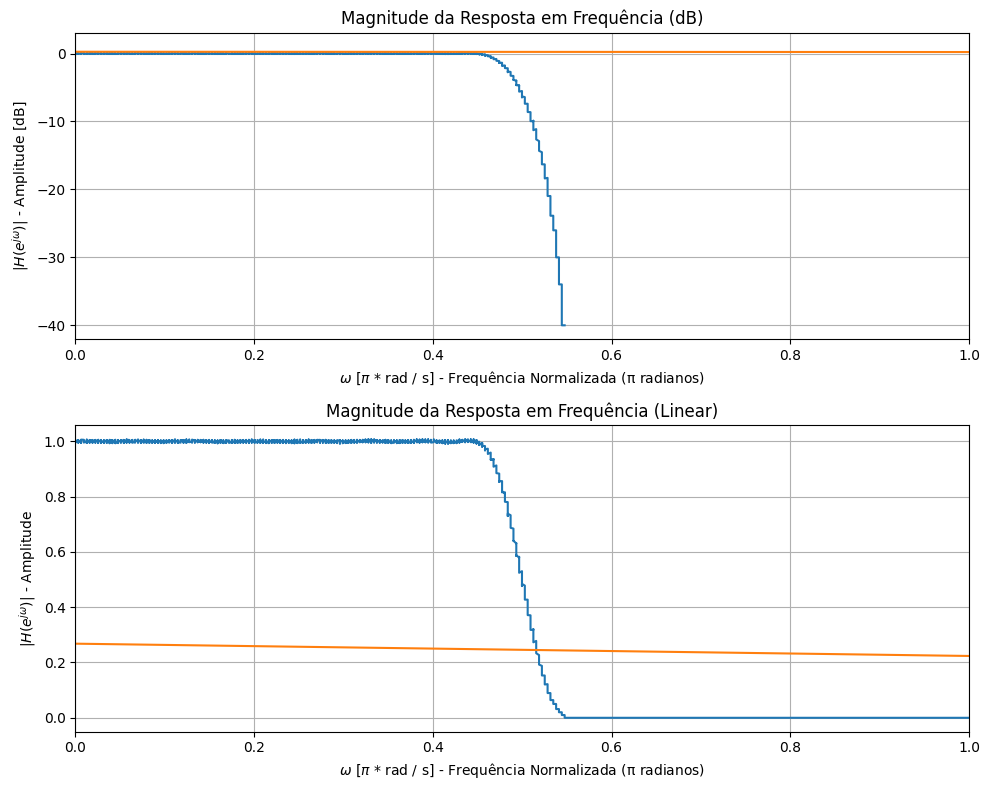

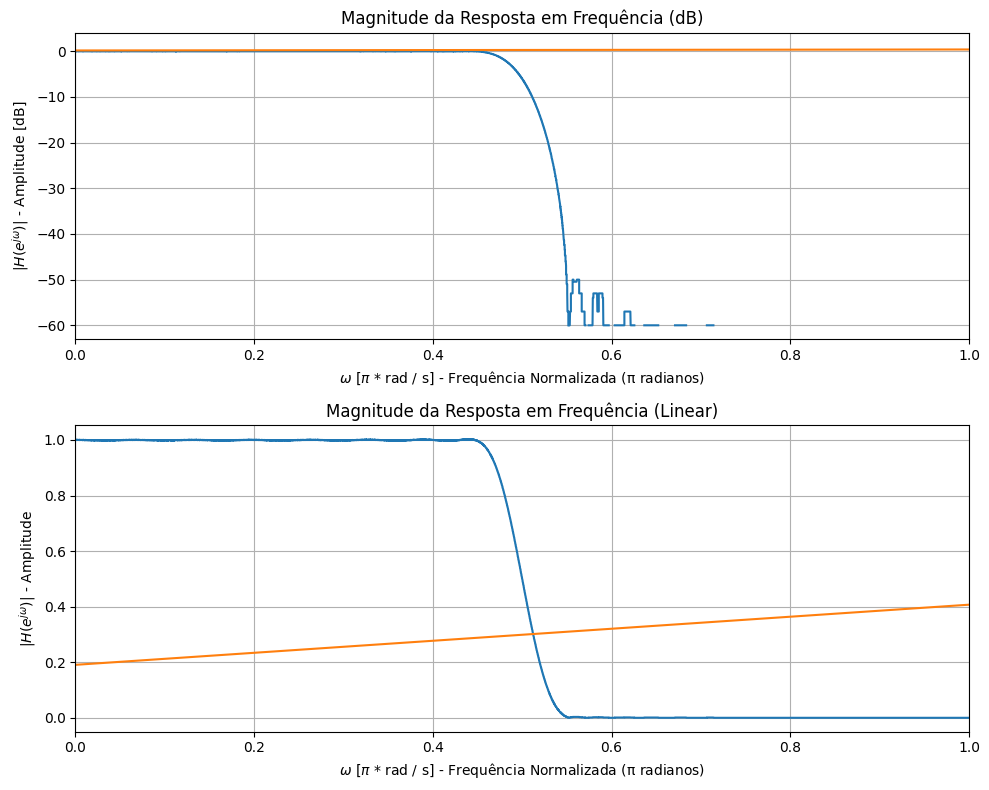

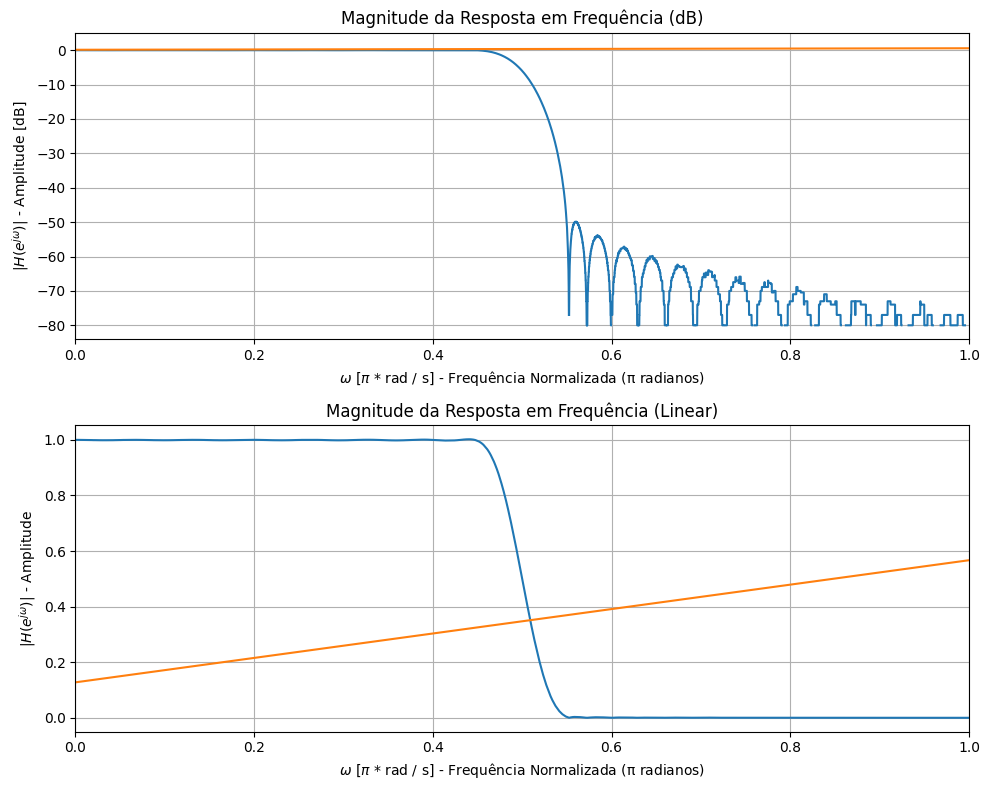

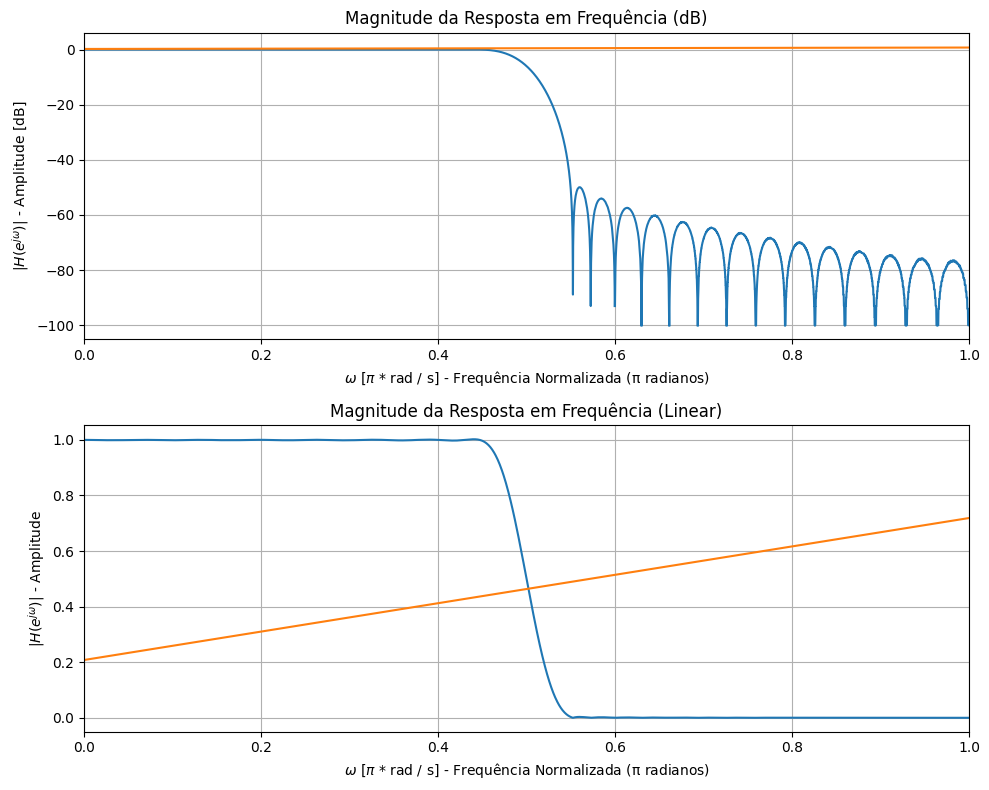

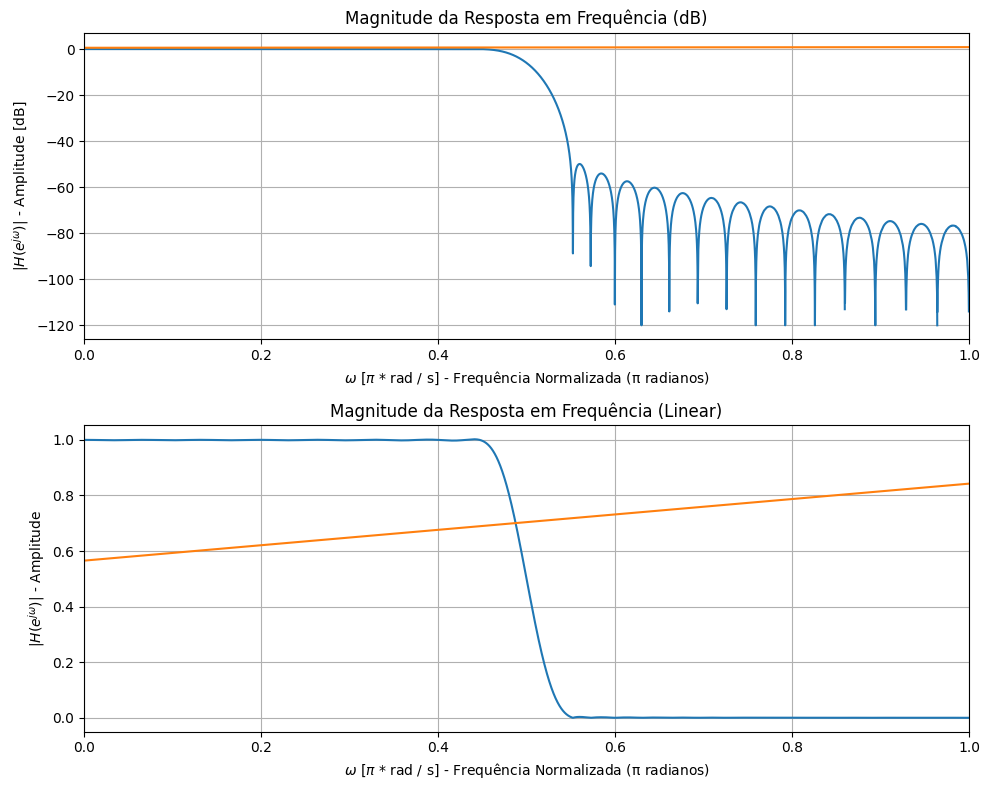

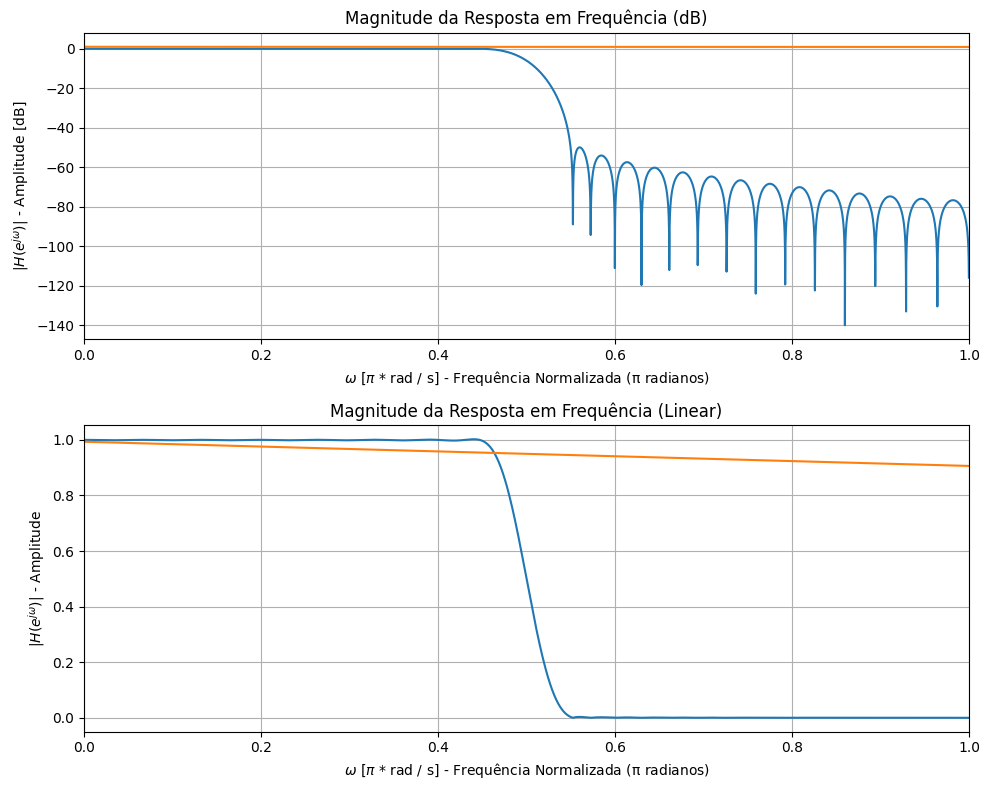

In [74]:
fig,axs = plt.subplots(2, 1, figsize=(12, 10))
min_casas = 1
max_casas = 8

# Obtendo um mapa de cores
cmap = cm.get_cmap('viridis', max_casas - min_casas)

# Iterando para plotar as respostas com diferentes precisões
for i, n_casas in enumerate(range(min_casas, max_casas)):
    # Arredonda os valores dos coeficientes
    _w = np.round(w, decimals=n_casas)
    _H = np.round(H, decimals=n_casas)
    
    # Usando a cor correspondente no mapa de cores
    color = cmap(i)
    
    plot_frequency_response_direct(_w, _H, color=color)


# axs[0].set_xlim([-0.05, 1.05])
# axs[0].legend([f"{n_casas} casas decimais" for n_casas in range(min_casas, max_casas)], loc="lower left")
# axs[0].axvline(wc / np.pi, color="k", linestyle="--")
# axs[0].grid()

# axs[1].set_xlim([-0.05, 1.05])
# axs[1].legend([f"{n_casas} casas decimais" for n_casas in range(min_casas, max_casas)], loc="lower left")
# axs[1].axvline(wc / np.pi, color="k", linestyle="--")
# axs[1].grid()

fig.suptitle("Resposta em frequência com variação da precisão - Forma direta")
fig.subplots_adjust(top=0.90, hspace=0.3)
plt.show()